In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import FinanceDataReader as fdr
import seaborn as sns
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df_ss = pdr.get_data_yahoo('005930.KS', '2018-01-01', '2019-12-31')

In [3]:
# df_ss = df_ss.fillna(0)
df_ss.dropna(axis=0, inplace=True)

In [4]:
df_ss.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-03,52560.0,51420.0,52540.0,51620.0,10013500.0,46235.468750
2018-01-04,52180.0,50640.0,52120.0,51080.0,11695450.0,45751.796875
2018-01-05,52120.0,51200.0,51300.0,52120.0,9481150.0,46683.312500
2018-01-08,52520.0,51500.0,52400.0,52020.0,8383650.0,46593.753906
2018-01-09,51720.0,49980.0,51460.0,50400.0,18013600.0,45142.734375


In [5]:
df_ss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 2018-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       487 non-null    float64
 1   Low        487 non-null    float64
 2   Open       487 non-null    float64
 3   Close      487 non-null    float64
 4   Volume     487 non-null    float64
 5   Adj Close  487 non-null    float64
dtypes: float64(6)
memory usage: 26.6 KB


In [7]:
# df_ss.drop(['dayline_10','Adj Close'], axis=1, inplace=True)

In [ ]:
df_ss.head()

In [8]:
split_size = int(df_ss.shape[0]*0.8)  #382
train = df_ss.iloc[:split_size]  #[:382]
test = df_ss.iloc[split_size:]   #[382:]
print(train.shape, test.shape)

(389, 6) (98, 6)


<AxesSubplot:xlabel='Date'>

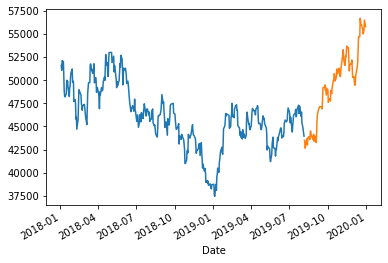

In [9]:
train['Close'].plot()
test['Close'].plot()

In [10]:
# y = df_ss['Close']
# X = df_ss.drop('Close', axis=1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaler = scaler.transform(train)
test_scaler  = scaler.transform(test)

In [11]:
train_scaler.shape, test_scaler.shape

((389, 6), (98, 6))

In [12]:
train_scaler[:10]

array([[0.904474  , 0.90216718, 0.9472693 , 0.91125402, 0.15481291,
        0.88005354],
       [0.8814994 , 0.85386997, 0.92090395, 0.87652733, 0.18081656,
        0.84341995],
       [0.87787183, 0.88854489, 0.86942875, 0.94340836, 0.14658255,
        0.91397349],
       [0.90205562, 0.90712074, 0.93848085, 0.93697749, 0.12961474,
        0.90719027],
       [0.85368803, 0.8130031 , 0.87947269, 0.83279743, 0.2784978 ,
        0.7972892 ],
       [0.78113664, 0.73003096, 0.81920904, 0.73247588, 0.28705051,
        0.69145859],
       [0.70495768, 0.69164087, 0.67482737, 0.69389068, 0.38842448,
        0.65075454],
       [0.65779927, 0.61362229, 0.67733836, 0.69131833, 0.42161258,
        0.64804119],
       [0.68802902, 0.68544892, 0.71249215, 0.71318328, 0.15608839,
        0.67110627],
       [0.75816203, 0.72879257, 0.70998117, 0.80707395, 0.31523253,
        0.77015277]])

In [13]:
train_scale_df = pd.DataFrame(train_scaler)
train_scale_df.columns = train.columns
test_scale_df = pd.DataFrame(test_scaler)
test_scale_df.columns = train.columns

y_train = train_scale_df['Close']
X_train = train_scale_df.drop('Close', axis=1)

y_test = test_scale_df['Close']
X_test = test_scale_df.drop('Close', axis=1)

In [14]:
X_train.shape, len(y_train)

((389, 5), 389)

In [15]:
X_test.shape, len(y_test)

((98, 5), 98)

# feature에 지수 관련 피쳐 넣을 것
당장은 뭐 없어서 위에서 연습한 수익률.. 이런것들을 사용

In [16]:
def my_dataset_window(xdata, ydata, window_size=5):
    window_size = 5
    xlist= []
    ylist = []
    # for i in range(train_scaler.shape[0] - window_size) :  #range(377)
    for i in range(window_size, xdata.shape[0]) :   #5,377   
        xvar = xdata[i-window_size: i]   #[0:5]  0,1,2,3,4
        yvar = ydata[i]    #Close
        xlist.append(xvar)
        ylist.append(yvar) 
    xlist = np.array(xlist)
    ylist = np.array(ylist)
    return xlist, ylist

X_train, y_train = my_dataset_window(X_train, y_train)
X_test, y_test = my_dataset_window(X_test, y_test)

In [17]:
print(X_train.shape)    
print(y_train.shape)  

(384, 5, 5)
(384,)


In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
# 모델 생성
model = Sequential()
model.add(LSTM(10, activation='relu',
               input_shape=(X_train.shape[1], X_train.shape[2])))  #(5,8)
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                640       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________


In [20]:
model = Sequential()
model.add(LSTM(units=50, activation="relu", return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation="relu", return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation="relu", return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 50)             11200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 60)             26640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 80)             45120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 80)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 120)              

In [21]:
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1, callbacks=[stop])

Epoch 1/200
22/22 [==============================] - 19s 137ms/step - loss: 0.2630 - mse: 0.2630 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 2/200
22/22 [==============================] - 1s 27ms/step - loss: 0.0546 - mse: 0.0546 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 3/200
22/22 [==============================] - 1s 36ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 4/200
22/22 [==============================] - 1s 40ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/200
22/22 [==============================] - 1s 29ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 6/200
22/22 [==============================] - 1s 25ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/200
22/22 [==============================] - 1s 24ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/200
22/22 [==============================] - 1s 36ms/step - loss: 

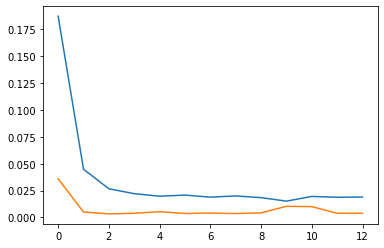

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label= 'val_loss')

In [23]:
pred = model.predict(X_test)

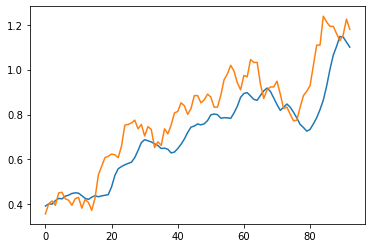

In [24]:
plt.plot(pred, label='pred')
plt.plot(y_test, label= 'y_test')